In [68]:
from pandas import *
import matplotlib.pyplot as plt
from ggplot import *
from pymongo import MongoClient

%matplotlib inline

In [132]:
mongo = MongoClient()
db = mongo.osm

raw = []
cursor = db.manchester_england.aggregate([
    {'$group': {'_id': {
                    'timestamp': {'$substr': ['$created.timestamp', 0, 10]}, 
                    'user': '$created.user',
                }, 
                'count': {'$sum': 1}}},
    {'$sort': {'_id': 1}}])
for doc in cursor:
    for k, v in doc.get('_id').iteritems():
        doc[k] = v
    del doc['_id']
        
    raw.append(doc)

df = DataFrame(raw)

df['month'] = to_datetime(df['timestamp'].apply(lambda x: x[:7] + '-01'))
df['timestamp'] = to_datetime(df['timestamp'])
df['year'] = df['timestamp'].apply(lambda x: x.year)
df['weekday'] = df['timestamp'].apply(lambda x: x.weekday())

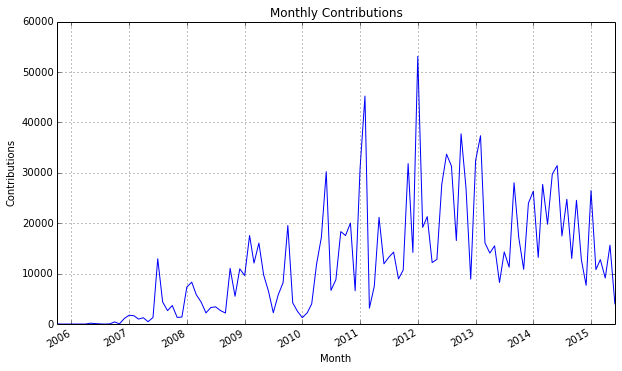

In [138]:
df.groupby('month')['count'].sum() \
    .plot(figsize=(10, 6), title='Monthly Contributions')
plt.xlabel('Month')
plt.ylabel('Contributions')
plt.show()

In [86]:
top_users = df.groupby('user', as_index=0)['count'].sum().sort('count', ascending=0)[:10].user.tolist()

In [105]:
top_users_contributions = df[df.user.isin(top_users)] \
    .pivot_table(index='month', columns='user', values='count', aggfunc=sum).sum().order() \
    / df['count'].sum()
    
top_users_contributions.sum()

0.46429109411351199

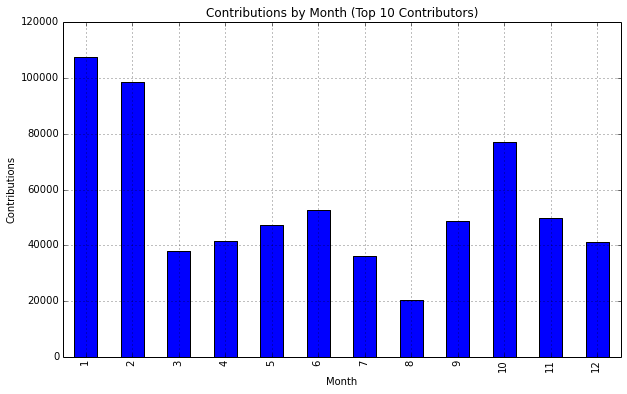

In [127]:
df[df.user.isin(top_users[:]) & (df.year < 2015)].assign(_month=df.month.apply(lambda x: x.month)) \
    .groupby(['_month'], as_index=1)['count'].sum() \
    .plot(kind='bar', figsize=(10, 6), title='Contributions by Month (Top 10 Contributors)')
# plt.ylim(0, 1e5)
plt.xlabel('Month')
plt.ylabel('Contributions')
plt.show()

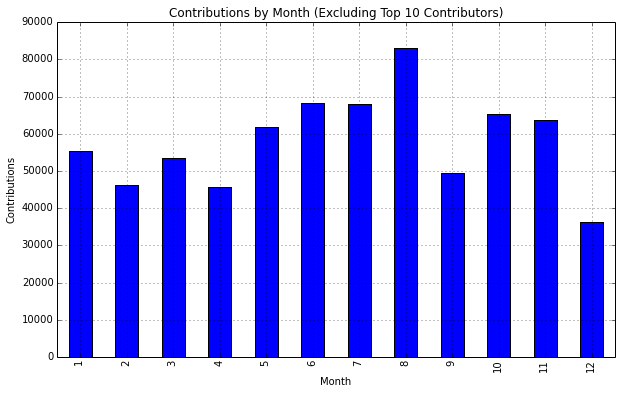

In [130]:
df[~df.user.isin(top_users[:]) & (df.year < 2015)].assign(_month=df.month.apply(lambda x: x.month)) \
    .groupby(['_month'], as_index=1)['count'].sum() \
    .plot(kind='bar', figsize=(10, 6), title='Contributions by Month (Excluding Top 10 Contributors)')
# plt.ylim(0, 1e5)
plt.xlabel('Month')
plt.ylabel('Contributions')
plt.show()

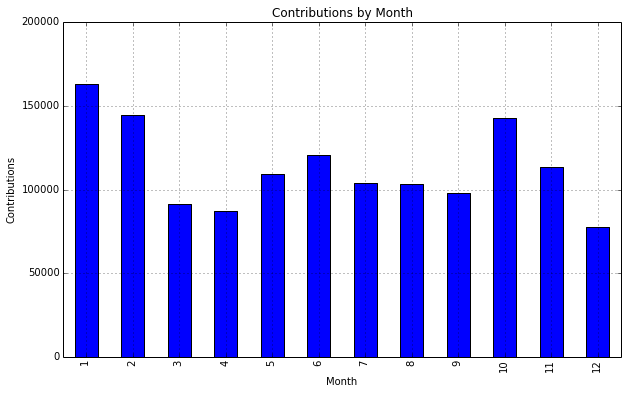

In [129]:
df[(df.year < 2015)].assign(_month=df.month.apply(lambda x: x.month)) \
    .groupby(['_month'], as_index=1)['count'].sum() \
    .plot(kind='bar', figsize=(10, 6), title='Contributions by Month')
plt.ylim(0, 2e5)
plt.xlabel('Month')
plt.ylabel('Contributions')
plt.show()

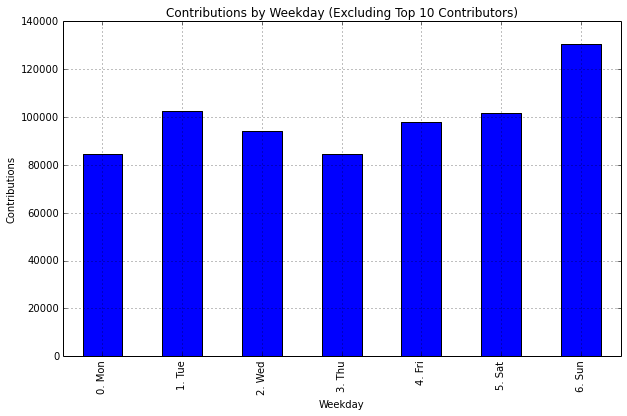

In [135]:
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

df[~df.user.isin(top_users[:]) & (df.year < 2015)] \
    .assign(weekday=df.weekday.apply(lambda x: str(x) + '. ' + weekdays[x])) \
    .groupby(['weekday'], as_index=1)['count'].sum() \
    .plot(kind='bar', figsize=(10, 6), title='Contributions by Weekday (Excluding Top 10 Contributors)')
# plt.ylim(0, 1e5)
plt.xlabel('Weekday')
plt.ylabel('Contributions')
plt.xticks()
plt.show()